### CLS Filter

(720, 540)
1.0


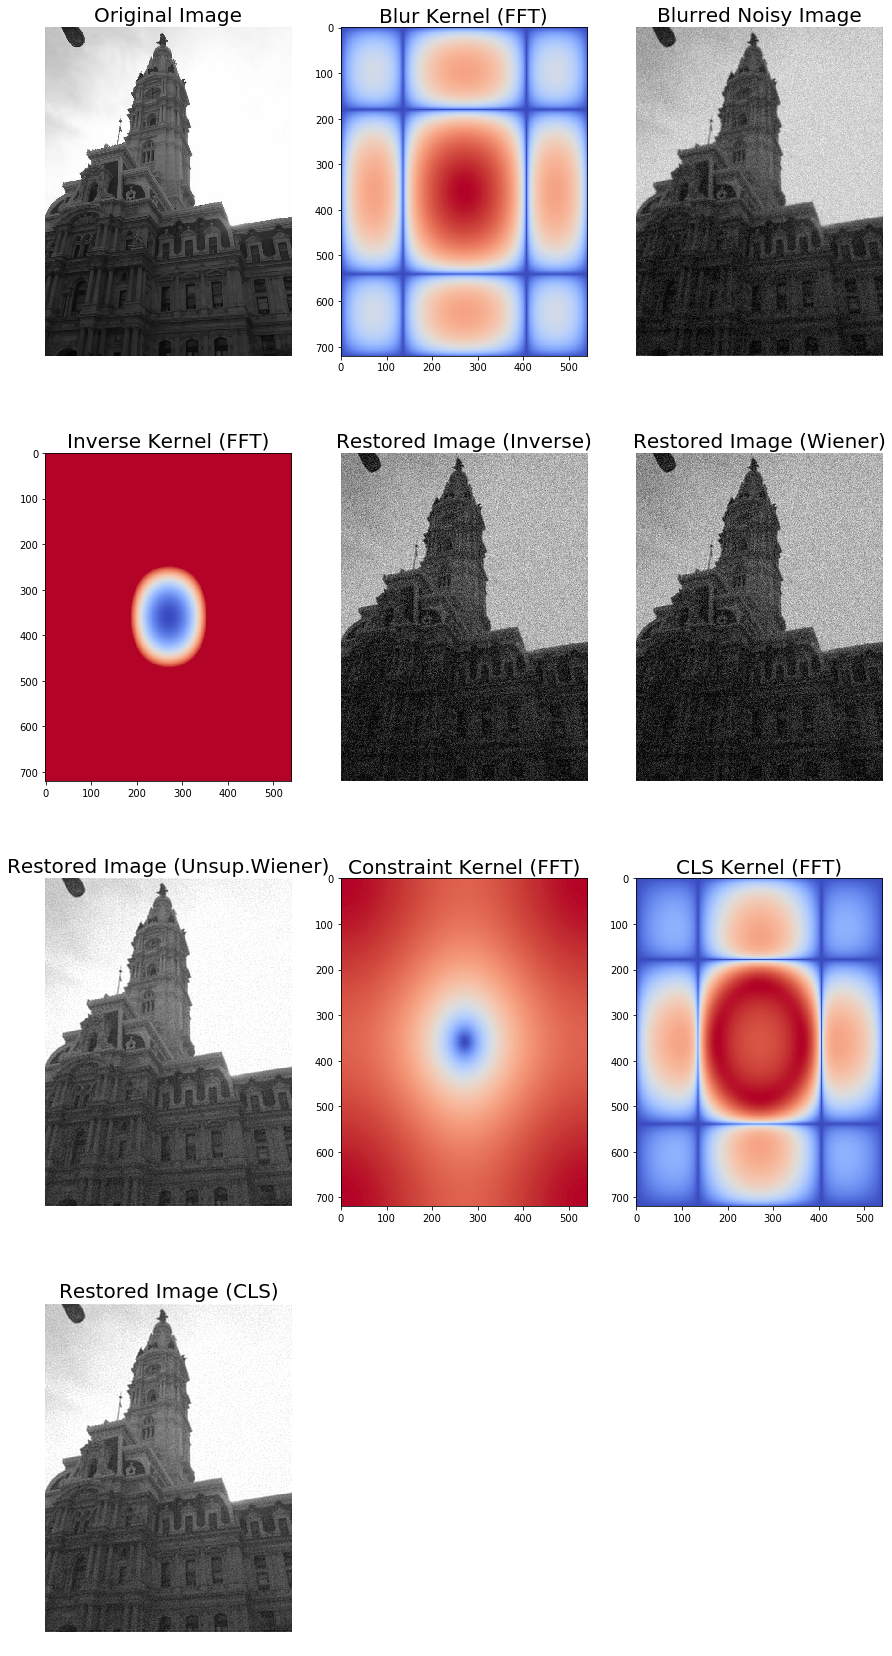

PSNR (Noisy): 24.581431378315315
PSNR (Inverse): 20.15514254324756
PSNR (Wiener): 29.35971490752089
PSNR (Unsup. Wiener): 28.518969896318946
PSNR (CLS): 31.09782698185443


In [68]:
% matplotlib inline
import numpy as np
import scipy.fftpack as fp
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.restoration import wiener, unsupervised_wiener
from skimage.measure import compare_psnr
import matplotlib.pylab as plt

def inverse_filter(y, h, gamma):
    n = 1 / gamma
    Hf = fp.fft2(fp.ifftshift(h))
    Hf[(np.abs(Hf)<n)] = n
    Hf = np.ones((M,N)) / Hf
    plt.imshow(20*np.log10( 0.01 + np.abs(fp.fftshift(Hf))), cmap='coolwarm'), plt.title('Inverse Kernel (FFT)', size=20)
    Yf = fp.fft2(y)
    I = Yf*Hf # 
    im = np.abs(fp.ifft2(I))
    return im

def cls_filter(y,h,c,alpha):
    Hf = fp.fft2(fp.ifftshift(h))
    Cf = fp.fft2(fp.ifftshift(c))
    Hf = np.conj(Hf) / (Hf*np.conj(Hf) + alpha*Cf*np.conj(Cf))
    plt.imshow(20*np.log10( 0.01 + np.abs(fp.fftshift(Hf))), cmap='coolwarm'), plt.title('CLS Kernel (FFT)', size=20)
    Yf = fp.fft2(y)
    I = Yf*Hf 
    im = np.abs(fp.ifft2(I))
    return im 


# Input and display the binary image
lambd = 0.1
x = rgb2gray(imread('images/building.jpg'))
print(x.shape)
M, N = x.shape
print(np.max(x))

plt.figure(figsize=(15,30))

plt.subplot(431), plt.imshow(x, cmap='gray'), plt.axis('off'), plt.title('Original Image', size=20)

# Blur the image, corrupt the image using WGN and display it
# h is the blurring filter, and sigma is the noise std
h = np.ones((4,4))/16
h = np.pad(h, [(M//2-2, M//2-2), (N//2-2, N//2-2)], mode='constant')
sigma = 0.05
Xf = fp.fft2(x)
Hf = fp.fft2(fp.ifftshift(h))

plt.subplot(432), plt.imshow(20*np.log10( 0.01 + np.abs(fp.fftshift(Hf))), cmap='coolwarm'), plt.title('Blur Kernel (FFT)', size=20)

Y = Hf*Xf
y = fp.ifft2(Y).real + sigma*np.random.normal(size=(M,N))

plt.subplot(433), plt.imshow(np.abs(y), cmap='gray'), plt.axis('off'), plt.title('Blurred Noisy Image', size=20)

# restoration using inverse filtering
gamma = 2
plt.subplot(434)
eix = inverse_filter(y, h, gamma)
plt.subplot(435), plt.imshow(eix, cmap='gray'), plt.axis('off'), plt.title('Restored Image (Inverse)', size=20)

# restoration using wiener filtering
ewx = wiener(y, h, balance=0.1)
plt.subplot(436), plt.imshow(eix, cmap='gray'), plt.axis('off'), plt.title('Restored Image (Wiener)', size=20)

# restoration using unsupervised wiener filtering
euwx, _ = unsupervised_wiener(y, h)
plt.subplot(437), plt.imshow(euwx, cmap='gray'), plt.axis('off'), plt.title('Restored Image (Unsup.Wiener)', size=20)

# restoration using cls filtering
alpha = 1
c =  np.array([[0,1/4,0],[1/4,-1,1/4],[0,1/4,0]])
c = np.pad(c, [(M//2-1, M//2-2), (N//2-2, N//2-1)], mode='constant')

Cf = fp.fft2(fp.ifftshift(c))
plt.subplot(438), plt.imshow(20*np.log10( 0.01 + np.abs(fp.fftshift(Cf))), cmap='coolwarm'), plt.title('Constraint Kernel (FFT)', size=20)

plt.subplot(439)
clx = cls_filter(y, h, c, alpha)

plt.subplot(4,3,10), plt.imshow(euwx, cmap='gray'), plt.axis('off'), plt.title('Restored Image (CLS)', size=20)

plt.show()

print('PSNR (Noisy): {}'.format(compare_psnr(x, y)))
print('PSNR (Inverse): {}'.format(compare_psnr(x, eix)))
print('PSNR (Wiener): {}'.format(compare_psnr(x, ewx)))
print('PSNR (Unsup. Wiener): {}'.format(compare_psnr(x, euwx)))
print('PSNR (CLS): {}'.format(compare_psnr(x, ecx)))